================================================================================
### Exploratory Data Analysis (EDA) - ImageArg Dataset (Gun Control)
================================================================================

This notebook explores the textual component of the ImageArg dataset focusing on the "gun control" topic. The goal is to understand dataset structure, label distribution, and key textual characteristics (tweets).

In [1]:
#Libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
sns.set_theme(palette="pastel")

#Path
path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
os.chdir(path)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Load Dataset - each split
train_df = pd.read_csv(f"{path}/data/train.csv")
train_df['split'] = 'train'

dev_df = pd.read_csv(f"{path}/data/dev.csv")
dev_df['split'] = 'dev'

test_df = pd.read_csv(f"{path}/data/test.csv")
test_df['split'] = 'test'

df = pd.concat([train_df, dev_df, test_df], ignore_index=True) 
df.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train
2,1151528583623585794,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train


### Columns Description

- **tweet_id**: Unique identifier of the tweet (string or integer).
- **tweet_url**: Original link to the tweet (not always needed for analysis).
- **tweet_text**: The text content of the tweet (our main focus for EDA).
- **stance**: Annotated argumentative stance towards gun control (support, oppose)
- **persuasiveness**: Whether the image (attached to the tweet) contributes to the persuasiveness of the argument (yes/no).
- **split**: Dataset split for experiments(train, val, test).

In [3]:
#Dataset shape
print("Dataset shape:", df.shape)

#Shape per splits
print(df['split'].value_counts())

#Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Dataset shape: (2314, 6)
split
train    1814
test      300
dev       200
Name: count, dtype: int64

Missing values per column:
tweet_id          0
tweet_url         0
tweet_text        0
stance            0
persuasiveness    0
split             0
dtype: int64


In [4]:
#Since we only want to analyze the train data for future preprocessing techniques or feature engineering 
#we will filter it

train_df = df[df['split'] == 'train'].copy()

Stance value counts:
 stance
oppose     1095
support     719
Name: count, dtype: int64


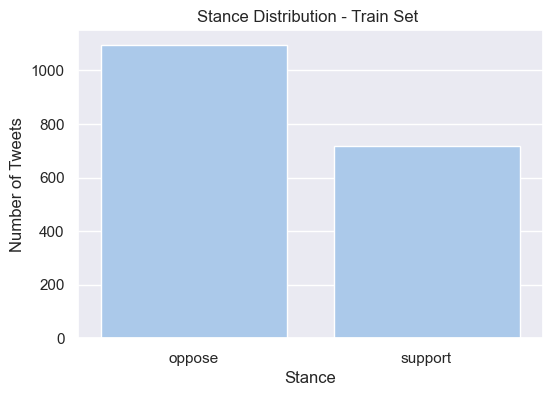


Persuasiveness value counts:
 persuasiveness
no     1285
yes     529
Name: count, dtype: int64


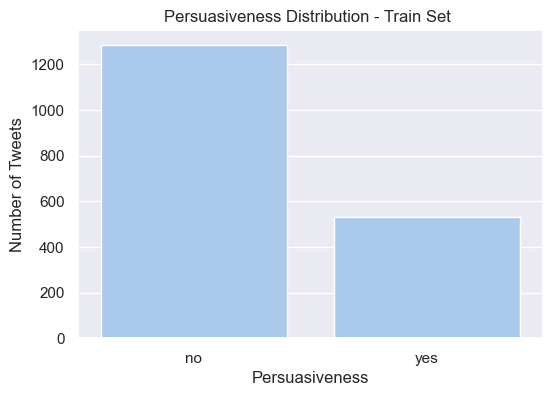

In [5]:
#Stance distribution
stance_counts = train_df['stance'].value_counts()
print("Stance value counts:\n", stance_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=stance_counts.index, y=stance_counts.values)
plt.title("Stance Distribution - Train Set ")
plt.ylabel("Number of Tweets")
plt.xlabel("Stance")
plt.show()

#Persuasiveness distribution
persuasion_counts = train_df['persuasiveness'].value_counts()
print("\nPersuasiveness value counts:\n", persuasion_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=persuasion_counts.index, y=persuasion_counts.values)
plt.title("Persuasiveness Distribution - Train Set ")
plt.ylabel("Number of Tweets")
plt.xlabel("Persuasiveness")
plt.show()


**Stance:** The dataset is relatively balanced, with 475 tweets supporting gun control and 448 opposing it.
**Persuasiveness:** Most images do not contribute to persuasiveness, with 672 labeled no versus 251 labeled yes.

Character count statistics:
count    1814.000000
mean      238.442117
std        67.127031
min        51.000000
25%       191.000000
50%       260.500000
75%       298.000000
max       335.000000
Name: char_count, dtype: float64

Word count statistics:
count    1814.000000
mean       33.687982
std        11.623374
min         4.000000
25%        25.000000
50%        36.000000
75%        43.000000
max        58.000000
Name: word_count, dtype: float64


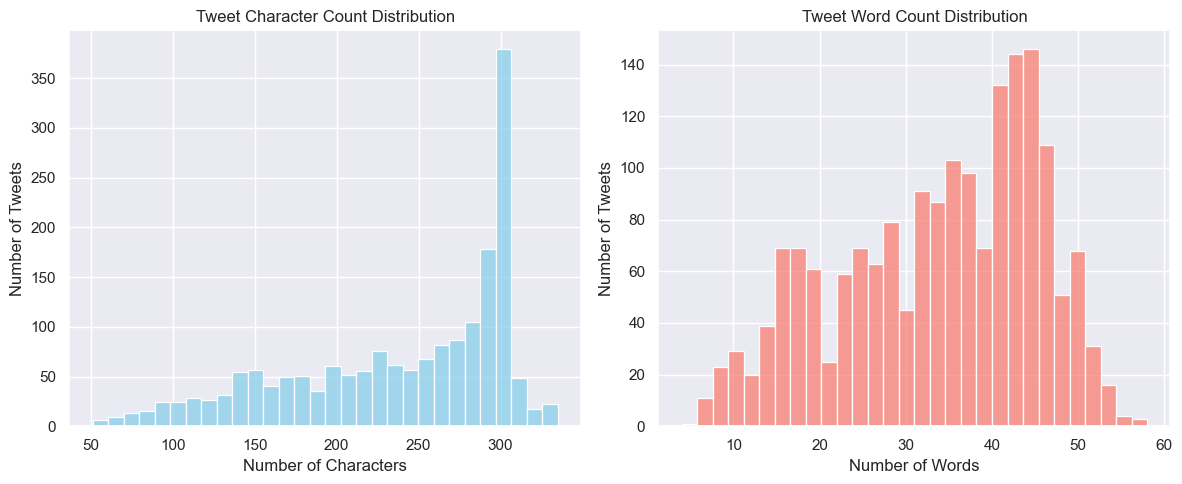

In [6]:
#Tweet Length 

#Add auxiliar lenght columns 
train_df['char_count'] = train_df['tweet_text'].apply(len)
train_df['word_count'] = train_df['tweet_text'].apply(lambda x: len(str(x).split()))


print("Character count statistics:")
print(train_df['char_count'].describe())
print("\nWord count statistics:")
print(train_df['word_count'].describe())

#Histograms
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(train_df['char_count'], bins=30, color='skyblue')
plt.title("Tweet Character Count Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Tweets")

plt.subplot(1,2,2)
sns.histplot(train_df['word_count'], bins=30, color='salmon')
plt.title("Tweet Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Tweets")

plt.tight_layout()
plt.show()


**Characters:** Tweets are moderately long, averaging ~245 characters, with most between 205 and 299 characters. Minimum length is 52, maximum 335.

**Words:** Tweets contain on average ~36 words, with the majority ranging from 28 to 44 words. Minimum is 6 words, maximum 58.

C:\Users\diego\AppData\Local\Temp\ipykernel_27140\1141770505.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts_nostop), y=list(words_nostop), palette="muted")


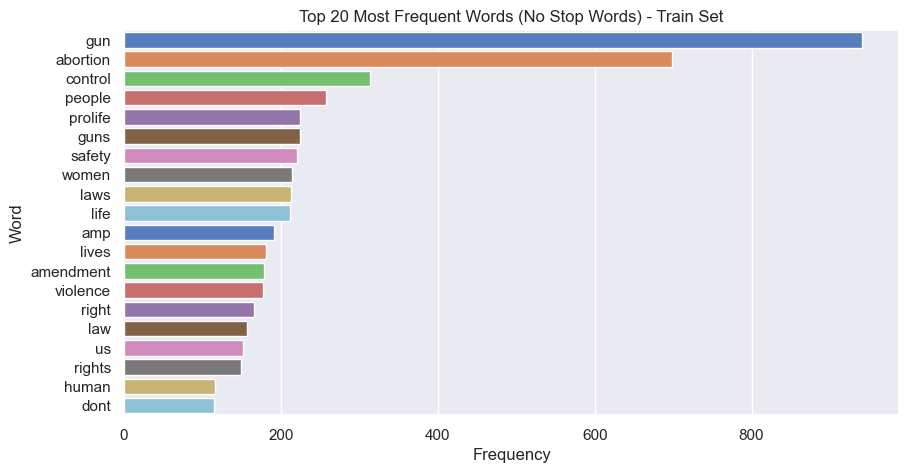

In [7]:
#Most Frequent Words - Train Set

#Text Cleaning simple function 
def clean_text(text):
    text = str(text).lower()    
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  
    text = re.sub(r"@\w+", "", text)            
    text = re.sub(r"#\w+", "", text)            
    text = re.sub(r"[^a-z\s]", "", text)       
    return text

#Clean Texts
train_df['clean_text'] = train_df['tweet_text'].apply(clean_text)


#Remove stopwords function
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

#Remove stopwrods
train_df['clean_text_nostop'] = train_df['clean_text'].apply(remove_stopwords)


all_words_nostop = " ".join(train_df['clean_text_nostop']).split()
word_freq_nostop = Counter(all_words_nostop)

# Top 20 most common words without stop words
most_common_words_nostop = word_freq_nostop.most_common(20)

#Plot top 20 words
words_nostop, counts_nostop = zip(*most_common_words_nostop)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts_nostop), y=list(words_nostop), palette="muted")
plt.title("Top 20 Most Frequent Words (No Stop Words) - Train Set")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_27140\3721432163.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="pastel")


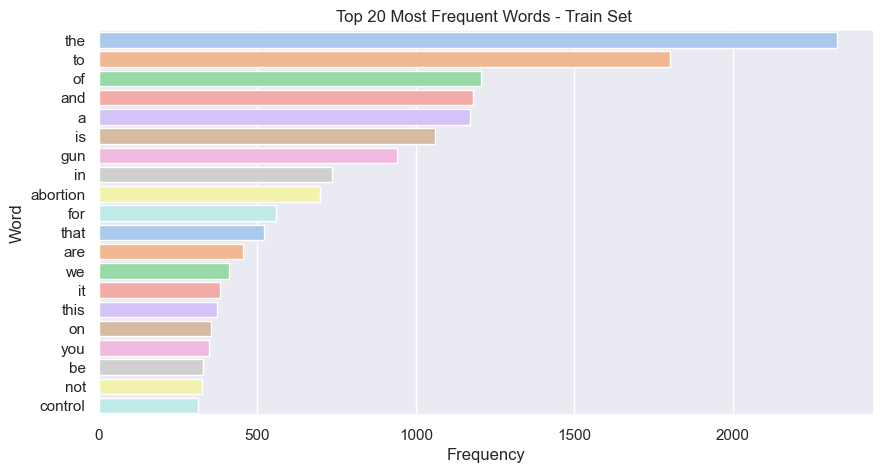

In [8]:

#Tokenize and count words
all_words = " ".join(train_df['clean_text']).split()
word_freq = Counter(all_words)

#Top 20 most common words
most_common_words = word_freq.most_common(20)

words, counts = zip(*most_common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette="pastel")
plt.title("Top 20 Most Frequent Words - Train Set ")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


C:\Users\diego\AppData\Local\Temp\ipykernel_27140\2653690632.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="pastel")


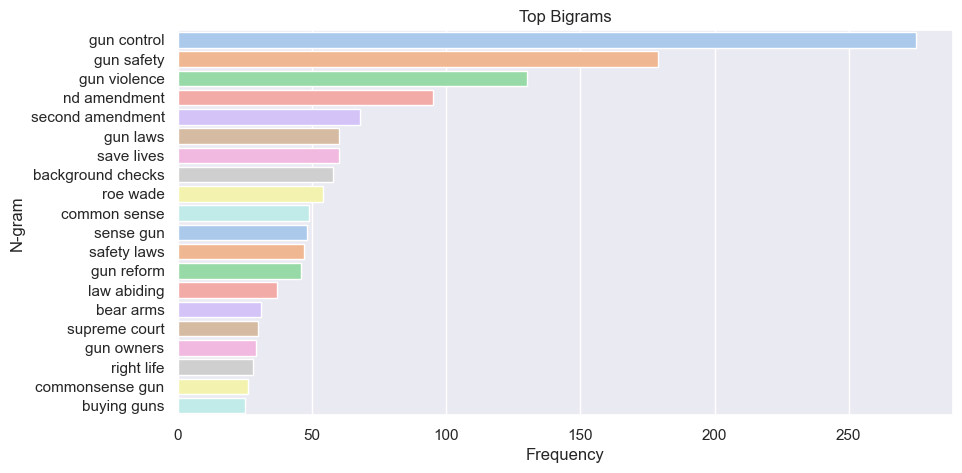

C:\Users\diego\AppData\Local\Temp\ipykernel_27140\2653690632.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="pastel")


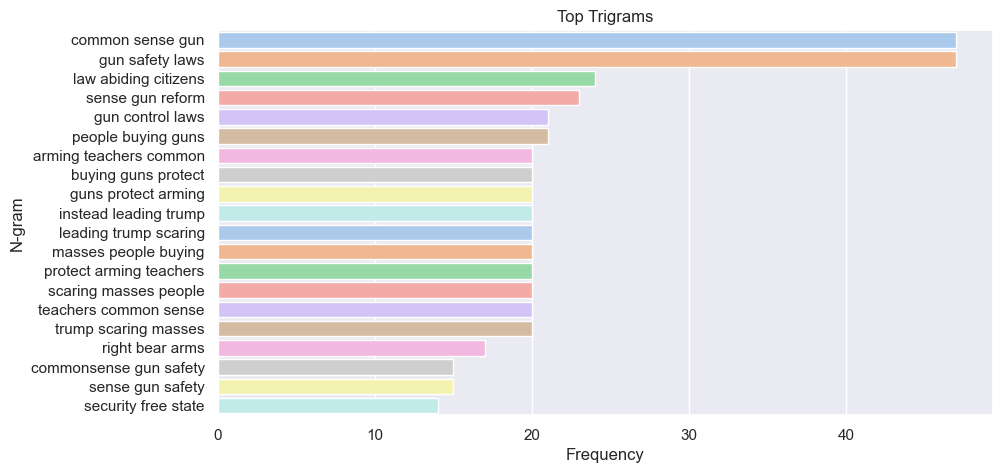

In [9]:
#Bigram and Trigram Analysis (without stop words)


#Bigram analysis
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X_bigrams = bigram_vectorizer.fit_transform(train_df['clean_text_nostop'])
bigram_counts = X_bigrams.sum(axis=0).A1
bigram_features = bigram_vectorizer.get_feature_names_out()
bigram_freq = dict(zip(bigram_features, bigram_counts))

#Trigram analysis
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), stop_words='english')
X_trigrams = trigram_vectorizer.fit_transform(train_df['clean_text_nostop'])
trigram_counts = X_trigrams.sum(axis=0).A1
trigram_features = trigram_vectorizer.get_feature_names_out()
trigram_freq = dict(zip(trigram_features, trigram_counts))


#Top 20 n-grams
top_bigrams = Counter(bigram_freq).most_common(20)
top_trigrams = Counter(trigram_freq).most_common(20)

#Plots
ngrams, counts = zip(*top_bigrams)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(ngrams), palette="pastel")
plt.title("Top Bigrams")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()

ngrams, counts = zip(*top_trigrams)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(ngrams), palette="pastel")
plt.title("Top Trigrams")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()


C:\Users\diego\AppData\Local\Temp\ipykernel_27140\907526444.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts1), y=list(ngrams1), palette="Blues_r")


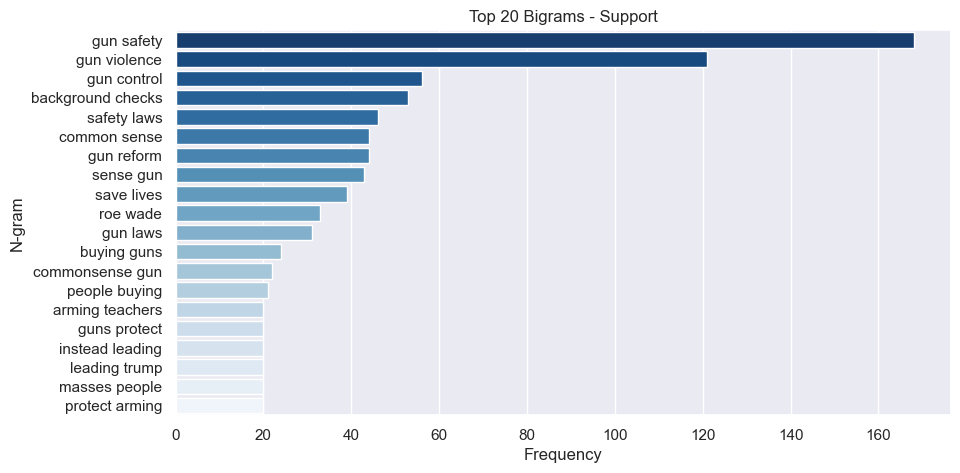

C:\Users\diego\AppData\Local\Temp\ipykernel_27140\907526444.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts1), y=list(ngrams1), palette="Reds_r")


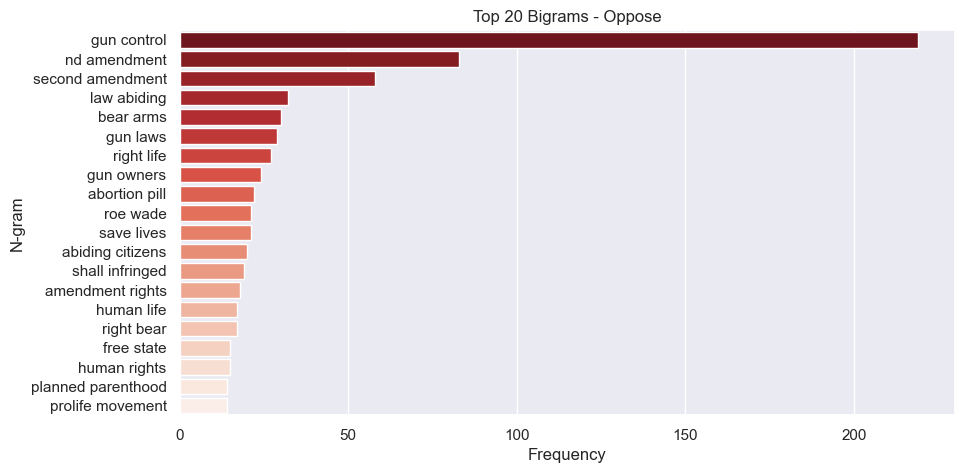

In [10]:
# N-gram Comparison by Stance - Train Set (without stop words)

#Split by stance
support_texts = train_df[train_df['stance']=='support']['clean_text_nostop']
oppose_texts = train_df[train_df['stance']=='oppose']['clean_text_nostop']

# Function to compute n-gram frequencies
def get_ngram_freq(text_series, ngram=2,stop_words='english'):
    vectorizer = CountVectorizer(ngram_range=(ngram,ngram), stop_words=stop_words)
    X = vectorizer.fit_transform(text_series)
    counts = X.sum(axis=0).A1
    features = vectorizer.get_feature_names_out()
    return dict(zip(features, counts))

#Compute bigram frequencies
support_bigrams = get_ngram_freq(support_texts, ngram=2)
oppose_bigrams = get_ngram_freq(oppose_texts, ngram=2)


#Plots
#Support
support = Counter(support_bigrams).most_common(20)
ngrams1, counts1 = zip(*support)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts1), y=list(ngrams1), palette="Blues_r")
plt.title(f"Top 20 Bigrams - Support")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()

#Oppose
oppose = Counter(oppose_bigrams).most_common(20)
ngrams1, counts1 = zip(*oppose)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts1), y=list(ngrams1), palette="Reds_r")
plt.title(f"Top 20 Bigrams - Oppose")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.show()